# Многоуровневая оптимизация
## Синтетический эксперемент: Минимизация функции Розенброка с помощью:

Low-fidelity (быстрая, шумная, приближённая)

High-fidelity (медленная, точная)

Использование стратегии вроде MFBO (multi-fidelity Bayesian optimization)

Графики затрат / точности / итераций

## Реальный эксперемент (только финальные графики или табличные результаты)

Приоритезация стека расчетов ИМА из Оптима

In [16]:
# =====================================
# 📍 1. Импорты и конфигурация окружения
# =====================================
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mlflow
from typing import List, Tuple, Dict, Callable
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import time 
import numpy as np
from skopt import gp_minimize
from time import sleep
import matplotlib.pyplot as plt
from collections import namedtuple
from functools import partial
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

np.random.seed(42)

In [17]:
# =====================================
# 🧪 2. Определение целевой функции
# =====================================

# Синтетическая задача: функция Розенброка, Растригина

def rosenbrock(x: list, noise=0.0, a = 1, b = 100):
    """
    Вычисляет значение функции Розенброка для заданного вектора x.

    Аргументы:
        x: Список или кортеж, представляющий точку в n-мерном пространстве.

    Возвращает:
        Значение функции Розенброка в точке x.
    """
    a = a
    b = b
    sum_val = 0
    for i in range(len(x) - 1):
        sum_val += (a - x[i])**2 + b * (x[i+1] - x[i]**2)**2
    return sum_val + np.random.normal(0, noise)



def rastrigin(x: list, noise=0.0, A = 10):
    """
    Вычисляет значение функции Растригина для заданного вектора x.

    Аргументы:
        x: Список или кортеж, представляющий точку в n-мерном пространстве.

    Возвращает:
        Значение функции Растригина в точке x.
    """
    x = np.array(x)
    n = len(x)
    
    sum_val = 0
    sum_val += np.sum(x**2 - A * np.cos(2 * np.pi * x))
    return A * n + sum_val + np.random.normal(0, noise)


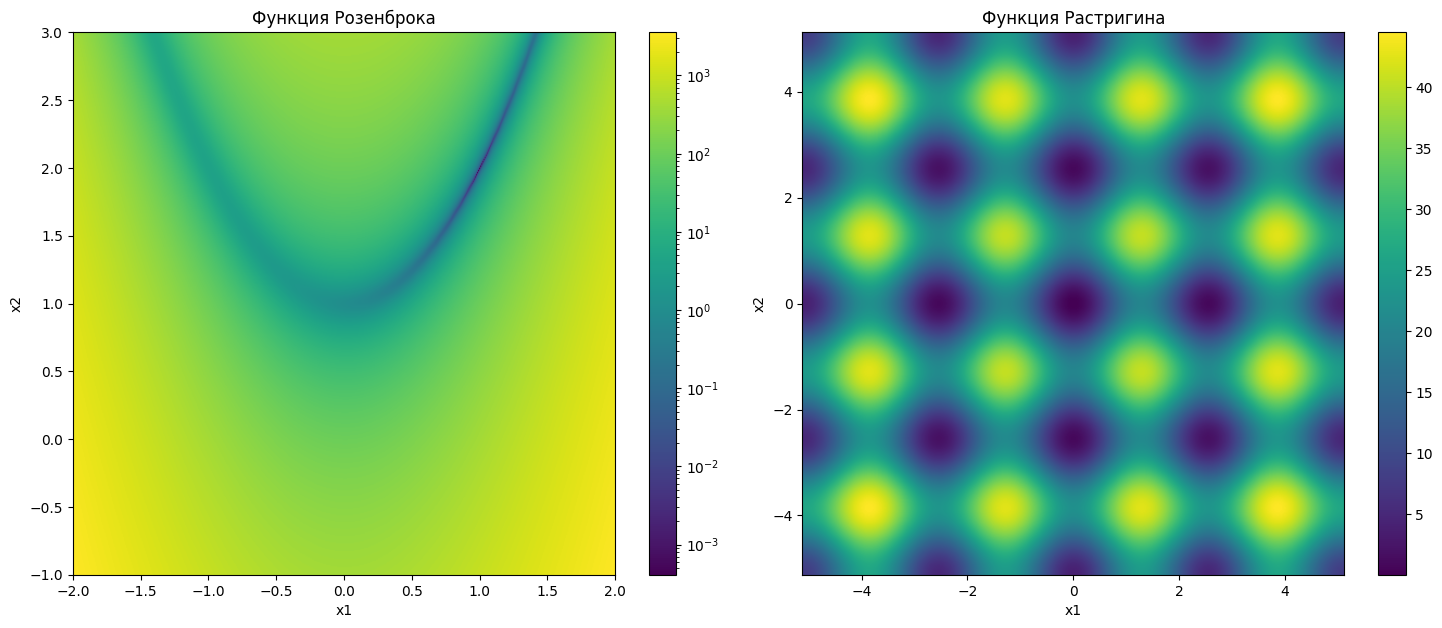

In [18]:
# =====================================
# 📊 3. Визуализация функций
# =====================================

# Построим контурные графики и сравним

def plot_2d_functions():
    # Создаем сетку для построения
    x = np.linspace(-2, 2, 500)
    y = np.linspace(-2, 2, 500)
    X, Y = np.meshgrid(x, y)
    
    # Вычисляем значения функций
    Z_rosenbrock = np.array([rosenbrock([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
    Z_rastrigin = np.array([rastrigin([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
    
    # Настройка графики
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # График функции Розенброка
    im1 = ax1.imshow(Z_rosenbrock, extent=[-2, 2, -1, 3], 
                    origin='lower', norm=LogNorm(), cmap='viridis')
    ax1.set_title('Функция Розенброка')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    fig.colorbar(im1, ax=ax1)
    
    # График функции Растригина
    im2 = ax2.imshow(Z_rastrigin, extent=[-5.12, 5.12, -5.12, 5.12], 
                    origin='lower', cmap='viridis')
    ax2.set_title('Функция Растригина')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    fig.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Запуск визуализации
plot_2d_functions()

In [19]:
# 2. Эмуляторы fidelity с исправлениями
def create_surrogate_function(target_fun, noise=0.0, delay=0.0):
    def surrogate_function(x):
        sleep(delay * 0) # Убрано время задержки для ускорения
        return target_fun(x, noise=noise)
    return surrogate_function

def fidelity_function(base_func, level: int):
    noise_levels = {1: 0.01, 2: 0.1, 3: 0.5}
    delay_levels = {1: 0.1, 2: 0.03, 3: 0.005}  # Вместо 1.0, 0.3, 0.05
    return create_surrogate_function(base_func, noise_levels[level], delay_levels[level])

mlflow ui

http://localhost:5000

In [137]:
def generate_grid(bounds, grid_size):
    x1 = np.linspace(bounds[0][0], bounds[0][1], grid_size)
    x2 = np.linspace(bounds[1][0], bounds[1][1], grid_size)
    grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)
    return grid


def density_weighting(stack, surrogate_models, gamma=1.0):
    # 1. Для каждого объекта — считаем дисперсию предсказаний ансамбля
    uncertainty = stack.apply(
        lambda row: np.var([model([row['x1'], row['x2']]) for model in surrogate_models]),
        axis=1
    ).values

    # 2. Для каждого объекта — считаем плотность через гауссовское ядро
    X = stack[['x1', 'x2']].values
    dists = euclidean_distances(X, X)  # матрица попарных расстояний
    density = np.exp(-gamma * dists ** 2).sum(axis=1)  # сумма ядер по строке

    # 3. Итоговый score: произведение неопределённости и плотности
    score = uncertainty * density

    # 4. Возвращаем top-1 объект с максимальным score
    idx = np.argmax(score)
    return stack.iloc[[idx]]


active_learning_strategies = {
    'random': lambda stack, surrogate_models: stack.sample(),
    'surrogate': lambda stack, surrogate_models: stack.loc[[stack.apply(lambda row: surrogate_models[-1]([row['x1'], row['x2']]), axis=1).idxmin()]],
    'variance_reduction': lambda stack, surrogate_models: stack.loc[[ stack.apply( lambda row: np.var([model([row['x1'], row['x2']]) for model in surrogate_models]), axis=1).idxmax()]],
    'density_weighting': lambda stack, surrogate_models: density_weighting(stack, surrogate_models, gamma=1.0)
}

class ForecastIMA:
    def __init__(self, 
    target_func, # целевая функция по которой идет поиск, например rosenbrock, rastrigin
    bounds = [(-5.0, 5.0), (-5.0, 5.0)], # границы поиска, например [(-5.0, 5.0), (-5.0, 5.0)]
    n_points = 22, # количество точек на сетке
    total_cost_budget=15, # сколько всего можно потратить на high_fidelity, low_fidelity и multifidelity расчеты (сделать запросов к target_func)
    active_learning_strategy = 'random',  # Стратегия выбора новой точки из 'Метод Нелдера–Мида' 'Variance Reduction', 'Density Weighting', 'random'
    fidelity_strategy = 'multifidelity', # Стратегия работы с fidelity моделями: 'hf_only', 'lf_only', 'multifidelity' (по умолчанию)
    ):
        # Условия поиска
        self.bounds = bounds
        self.target_func = target_func
        self.n_points = n_points
        self.total_cost_budget = total_cost_budget
        self.stack = pd.DataFrame(generate_grid(bounds = self.bounds, grid_size=self.n_points), columns=['x1', 'x2'])

        # Метод поиска
        self.high_fidelity_model = fidelity_function(self.target_func, level=1)  # Высокоточная модель (HF)
        self.low_fidelity_models = [fidelity_function(self.target_func, level=3), fidelity_function(self.target_func, level = 2)] # TODO: переделать на linear ML

        self.fidelity_strategy = fidelity_strategy  # 'hf_only', 'lf_only', 'multifidelity'
        self.active_learning_strategy = active_learning_strategies[active_learning_strategy]
        
        
        
        # Логирование и результаты
        self.high_fidelity_points = pd.DataFrame(columns=['x1', 'x2', 'y'])  # Точки с высокоточной моделью (HF)
        self.result = pd.DataFrame(columns=['model', 'x', 'y'])
        self.best_point = None  # Лучшая точка, найденная в процессе поиска
        self.MAPE = None  # Mean Absolute Percentage Error (MAPE) для оценки качества модели
        self.MAE = None  # Mean Absolute Error (MAE) для оценки качества модели
        self.regret = None  # Регрет для оценки качества модели

    def run_forecast(self):
        """Запускает поиск с заданным количеством шагов n_steps"""
        for step in range(self.total_cost_budget):
            self.step()
            if self.fidelity_strategy == 'multifidelity':
                self.low_fidelity_models.append(fidelity_function(self.target_func, level=3)) #.fit(self.high_fidelity_points.X, self.high_fidelity_points.y)
        self.best_point = self.high_fidelity_points.loc[self.high_fidelity_points['y'].idxmin()]
        self.regret = self.best_point['y']
        # self.MAPE = mape(self.high_fidelity_points['y'], self.target_func(self.high_fidelity_points[['x1', 'x2']].values.T.tolist()))

    def step(self):
        """Выполняет один шаг, запрос high_fidelity к target_func согласно текущей стратегии self.active_learning_strategy"""
        if self.stack.empty:
            print("Stack is empty! Эксперимент закончен.")
            return
        new_point = self.active_learning_strategy(self.stack, self.low_fidelity_models) # Используем суррогатную модель для выбора точки
        self.stack = self.stack.drop(new_point.index)  # Удаляем выбранную точку из стека расчетов
        self.high_fidelity_points.loc[len(self.high_fidelity_points)] = {'x1' : new_point.x1.iloc[0], 'x2' : new_point.x2.iloc[0], 'y' : self.high_fidelity_model([new_point.x1.iloc[0], new_point.x2.iloc[0]])}


## Многомасштабное моделирование
### Розенброк

In [138]:


n_points=100
target_func=rosenbrock

experiment_high_fidelity = ForecastIMA(target_func=target_func,
    n_points=n_points,
    active_learning_strategy='random',
    fidelity_strategy='high_fidelity'
)

experiment_low_fidelity = ForecastIMA(target_func=target_func,
    n_points=n_points,
    active_learning_strategy='random',
    fidelity_strategy='low_fidelity'
)
experiment_low_fidelity.high_fidelity_model = experiment_low_fidelity.low_fidelity_models[0]  # Используем первую модель низкой точности в качестве высокоточной

experiment_multifidelity = ForecastIMA(target_func=target_func,
    n_points=n_points,
    active_learning_strategy='surrogate',
    fidelity_strategy='multifidelity' 
)


In [139]:
# Теперь просто запускаем каждый эксперимент и сравниваем результаты:

experiments = {
    "High-Fidelity": experiment_high_fidelity,
    "Low-Fidelity": experiment_low_fidelity,
    "Multifidelity": experiment_multifidelity
}

results = {}

for name, exp in experiments.items():
    t0 = time.time()
    exp.run_forecast()
    elapsed = time.time() - t0

    # Найденная лучшая точка и её значение
    idx_best = exp.high_fidelity_points['y'].idxmin()
    best_point = exp.high_fidelity_points.loc[idx_best]

    # Истинное значение функции в найденной точке (с гарантированным float)
    true_y = exp.target_func([float(best_point['x1']), float(best_point['x2'])], noise=0.0)
    pred_y = best_point['y']

    mae_best = mae([true_y] , [pred_y])  

    results[name] = {
        'x': [float(best_point['x1']), float(best_point['x2'])],
        'true_y': true_y,
        'pred_y': pred_y,
        'steps': len(exp.high_fidelity_points),
        'time': elapsed,
        'mae_best': mae_best
    }

# Вывод
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Найденная точка: {np.round(res['x'], 6)}")
    print(f"  Истинное значение функции: {res['true_y']:.8f}")
    print(f"  Предсказанное значение: {res['pred_y']:.8f}")
    print(f"  Число шагов: {res['steps']}")
    print(f"  Время, сек: {res['time']:.2f}")
    print(f"  MAE в лучшей точке: {res['mae_best']:.8f}")


High-Fidelity:
  Найденная точка: [-0.454545 -0.050505]
  Истинное значение функции: 8.72659815
  Предсказанное значение: 8.73646632
  Число шагов: 15
  Время, сек: 0.03
  MAE в лучшей точке: 0.00986817

Low-Fidelity:
  Найденная точка: [-0.757576 -0.959596]
  Истинное значение функции: 238.25650781
  Предсказанное значение: 237.10349521
  Число шагов: 15
  Время, сек: 0.01
  MAE в лучшей точке: 1.15301260

Multifidelity:
  Найденная точка: [1.161616 1.363636]
  Истинное значение функции: 0.04652378
  Предсказанное значение: 0.05735916
  Число шагов: 15
  Время, сек: 0.57
  MAE в лучшей точке: 0.01083538


## Многомасштабное моделирование
### Растригин

In [10]:
bounds = [(-5.0, 5.0), (-5.0, 5.0)]
total_cost_budget = 15
n_points=100
target_func=rastrigin

experiment_high_fidelity = ForecastIMA(target_func=target_func,
    bounds=bounds,
    n_points=n_points,
    total_cost_budget=total_cost_budget,
    active_learning_strategy='random',
    fidelity_strategy='high_fidelity'
)

experiment_low_fidelity = ForecastIMA(target_func=target_func,
    bounds=bounds,
    n_points=n_points,
    total_cost_budget=total_cost_budget,
    active_learning_strategy='random',
    fidelity_strategy='low_fidelity'
)
experiment_low_fidelity.high_fidelity_model = experiment_low_fidelity.low_fidelity_models[0]  # Используем первую модель низкой точности в качестве высокоточной

experiment_multifidelity = ForecastIMA(target_func=target_func,
    bounds=bounds,
    n_points=n_points,        
    total_cost_budget=total_cost_budget,
    active_learning_strategy='surrogate',
    fidelity_strategy='multifidelity' 
)


In [11]:
# Теперь просто запускаем каждый эксперимент и сравниваем результаты:

experiments = {
    "High-Fidelity": experiment_high_fidelity,
    "Low-Fidelity": experiment_low_fidelity,
    "Multifidelity": experiment_multifidelity
}

results = {}

for name, exp in experiments.items():
    t0 = time.time()
    exp.run_forecast()
    elapsed = time.time() - t0

    # Найденная лучшая точка и её значение
    idx_best = exp.high_fidelity_points['y'].idxmin()
    best_point = exp.high_fidelity_points.loc[idx_best]

    # Истинное значение функции в найденной точке (с гарантированным float)
    true_y = exp.target_func([float(best_point['x1']), float(best_point['x2'])], noise=0.0)
    pred_y = best_point['y']

    mae_best = mae([true_y] , [pred_y])  

    results[name] = {
        'x': [float(best_point['x1']), float(best_point['x2'])],
        'true_y': true_y,
        'pred_y': pred_y,
        'steps': len(exp.high_fidelity_points),
        'time': elapsed,
        'mae_best': mae_best
    }

# Вывод
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Найденная точка: {np.round(res['x'], 6)}")
    print(f"  Истинное значение функции: {res['true_y']:.8f}")
    print(f"  Предсказанное значение: {res['pred_y']:.8f}")
    print(f"  Число шагов: {res['steps']}")
    print(f"  Время, сек: {res['time']:.2f}")
    print(f"  MAE в лучшей точке: {res['mae_best']:.8f}")


High-Fidelity:
  Найденная точка: [-3.080808  1.060606]
  Истинное значение функции: 12.59409055
  Предсказанное значение: 12.59931689
  Число шагов: 15
  Время, сек: 0.05
  MAE в лучшей точке: 0.00522635

Low-Fidelity:
  Найденная точка: [0.252525 1.060606]
  Истинное значение функции: 12.06363453
  Предсказанное значение: 11.58963439
  Число шагов: 15
  Время, сек: 0.01
  MAE в лучшей точке: 0.47400014

Multifidelity:
  Найденная точка: [-0.050505 -0.050505]
  Истинное значение функции: 1.00367917
  Предсказанное значение: 0.99133625
  Число шагов: 15
  Время, сек: 1.10
  MAE в лучшей точке: 0.01234291


# Активное обучение

In [44]:


bounds = [(-5.0, 5.0), (-5.0, 5.0)]
total_cost_budget = 100
n_points=100
target_func=rosenbrock

experiment_multifidelity_random = ForecastIMA(target_func=target_func,
    bounds=bounds,
    n_points=n_points,
    total_cost_budget=total_cost_budget,
    active_learning_strategy='random',
    fidelity_strategy='multifidelity'
)

experiment_multifidelity_variance_reduction = ForecastIMA(target_func=target_func,
    bounds=bounds,
    n_points=n_points,
    total_cost_budget=total_cost_budget,
    active_learning_strategy='variance_reduction',
    fidelity_strategy='multifidelity'
)

experiment_multifidelity_density_weighting = ForecastIMA(target_func=target_func,
    bounds=bounds,
    n_points=n_points,
    total_cost_budget=total_cost_budget,
    active_learning_strategy='density_weighting',
    fidelity_strategy='multifidelity'
)



In [27]:
# Теперь просто запускаем каждый эксперимент и сравниваем результаты:

experiments = {
    "Random active" : experiment_multifidelity_random,
    "Variance reduction" : experiment_multifidelity_variance_reduction,
    "Density weighting" : experiment_multifidelity_density_weighting
}

results = {}

for name, exp in experiments.items():
    t0 = time.time()
    exp.run_forecast()
    elapsed = time.time() - t0

    # Найденная лучшая точка и её значение
    idx_best = exp.high_fidelity_points['y'].idxmin()
    best_point = exp.high_fidelity_points.loc[idx_best]

    # Истинное значение функции в найденной точке (с гарантированным float)
    true_y = exp.target_func([float(best_point['x1']), float(best_point['x2'])], noise=0.0)
    pred_y = best_point['y']

    mae_best = mae([true_y] , [pred_y])  

    results[name] = {
        'x': [float(best_point['x1']), float(best_point['x2'])],
        'true_y': true_y,
        'pred_y': pred_y,
        'steps': len(exp.high_fidelity_points),
        'time': elapsed,
        'mae_best': mae_best
    }

# Вывод
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Найденная точка: {np.round(res['x'], 6)}")
    print(f"  Отставание от оптимума: {res['true_y']:.8f}")
    print(f"  Предсказанное значение: {res['pred_y']:.8f}")
    print(f"  Число шагов: {res['steps']}")
    print(f"  Время, сек: {res['time']:.2f}")
    print(f"  MAE в лучшей точке: {res['mae_best']:.8f}")


Random active:
  Найденная точка: [-1.969697 -2.474747]
  Отставание от оптимума: 4046.72719009
  Предсказанное значение: 4046.71861269
  Число шагов: 1
  Время, сек: 0.01
  MAE в лучшей точке: 0.00857740

Variance reduction:
  Найденная точка: [ 4.89899  -2.474747]
  Отставание от оптимума: 70106.96775428
  Предсказанное значение: 70106.96215551
  Число шагов: 1
  Время, сек: 0.14
  MAE в лучшей точке: 0.00559877

Density weighting:
  Найденная точка: [-2.878788  3.585859]
  Отставание от оптимума: 2225.51264039
  Предсказанное значение: 2225.50166912
  Число шагов: 1
  Время, сек: 1.59
  MAE в лучшей точке: 0.01097126


In [267]:

results

,run,strategy,budget,y_true,y_pred,x


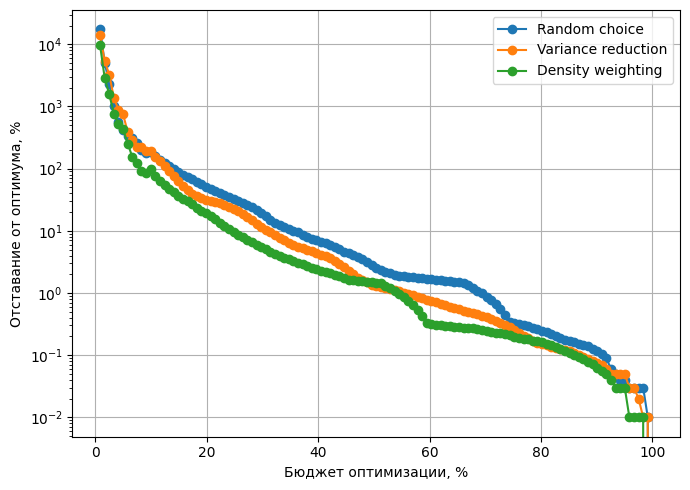

In [309]:
import numpy as np
import matplotlib.pyplot as plt

n_repeats = 100

bounds = [(-5.0, 5.0), (-5.0, 5.0)]
total_cost_budget = 1 # костыль для отрисловки по шагам
n_points = 11
target_func = rosenbrock

experiment_params = {
    "Random choice": {
        'active_learning_strategy': 'random'
    },
    "Variance reduction": {
        'active_learning_strategy': 'variance_reduction'
    },
    "Density weighting": {
        'active_learning_strategy': 'density_weighting'
    }
}

plt.figure(figsize=(7, 5))

for name, params in experiment_params.items():
    all_y_hists = []
    all_budget_hists = []

    for repeat in range(n_repeats):

        np.random.seed(repeat)
        exp = ForecastIMA(
            target_func=target_func,
            bounds=bounds,
            n_points=n_points,
            total_cost_budget=total_cost_budget,
            active_learning_strategy=params['active_learning_strategy'],
            fidelity_strategy='multifidelity'
        )

        y_hist = []
        budget_hist = []
        min_so_far = np.inf

        for i in range(n_points ** 2):
            exp.run_forecast()
            row = exp.best_point
            val = exp.target_func([float(row['x1']), float(row['x2'])], noise=0.0)
            if val < min_so_far:
                min_so_far = val
            rel_gap = abs(min_so_far)
            y_hist.append(rel_gap)
            budget_hist.append(100 * (i + 1) / exp.n_points ** 2)

        all_y_hists.append(y_hist)
        all_budget_hists.append(budget_hist)

    mean_y_hist = np.mean(all_y_hists, axis=0)
    mean_budget_hist = np.mean(all_budget_hists, axis=0)
    var_y_hist = np.var(all_y_hists, axis=0)
    std_y_hist = np.sqrt(var_y_hist)

    # Сглаживаем mean_y_hist (оставляем по краям 11 точек, середину сглаживаем)
    smoothed_mean_y_hist = np.array([
        mean_y_hist[i] if i < 11 or i >= len(mean_y_hist) - 11 else np.mean(mean_y_hist[i - 5:i + 5])
        for i in range(len(mean_y_hist))
    ])
    mean_y_hist = smoothed_mean_y_hist
    """
    # === КОРИДОР: визуализация разброса ===
    plt.fill_between(
        mean_budget_hist,
        mean_y_hist - std_y_hist,
        mean_y_hist + std_y_hist,
        alpha=0.2,  # прозрачность коридора
        label=None
    )
    """
    plt.plot(mean_budget_hist, mean_y_hist, marker='o', label=name)

plt.xlabel('Бюджет оптимизации, %')
plt.ylabel('Отставание от оптимума, %')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


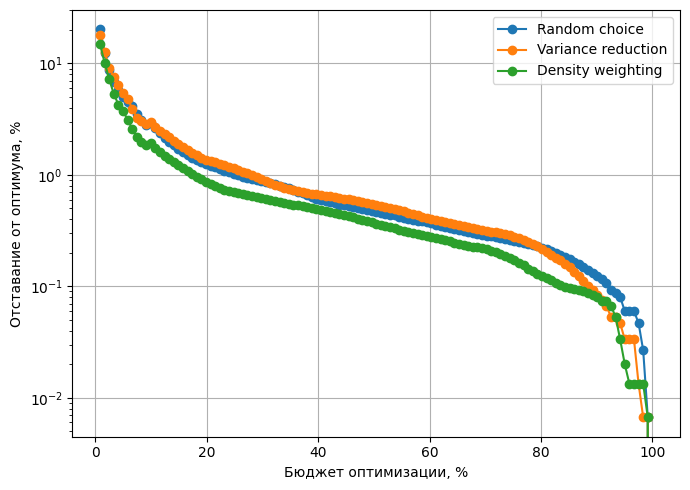

In [310]:
import numpy as np
import matplotlib.pyplot as plt

n_repeats = 150

bounds = [(-5.0, 5.0), (-5.0, 5.0)]
total_cost_budget = 1 # костыль для отрисловки по шагам
n_points = 11
target_func = rastrigin

experiment_params = {
    "Random choice": {
        'active_learning_strategy': 'random'
    },
    "Variance reduction": {
        'active_learning_strategy': 'variance_reduction'
    },
    "Density weighting": {
        'active_learning_strategy': 'density_weighting'
    }
}

plt.figure(figsize=(7, 5))

for name, params in experiment_params.items():
    all_y_hists = []
    all_budget_hists = []

    for repeat in range(n_repeats):

        np.random.seed(repeat)
        exp = ForecastIMA(
            target_func=target_func,
            bounds=bounds,
            n_points=n_points,
            total_cost_budget=total_cost_budget,
            active_learning_strategy=params['active_learning_strategy'],
            fidelity_strategy='multifidelity'
        )

        y_hist = []
        budget_hist = []
        min_so_far = np.inf

        for i in range(n_points ** 2):
            exp.run_forecast()
            row = exp.best_point
            val = exp.target_func([float(row['x1']), float(row['x2'])], noise=0.0)
            if val < min_so_far:
                min_so_far = val
            rel_gap = abs(min_so_far)
            y_hist.append(rel_gap)
            budget_hist.append(100 * (i + 1) / exp.n_points ** 2)

        all_y_hists.append(y_hist)
        all_budget_hists.append(budget_hist)

    mean_y_hist = np.mean(all_y_hists, axis=0)
    mean_budget_hist = np.mean(all_budget_hists, axis=0)
    var_y_hist = np.var(all_y_hists, axis=0)
    std_y_hist = np.sqrt(var_y_hist)

    # Сглаживаем mean_y_hist (оставляем по краям 11 точек, середину сглаживаем)
    smoothed_mean_y_hist = np.array([
        mean_y_hist[i] if i < 11 or i >= len(mean_y_hist) - 11 else np.mean(mean_y_hist[i - 5:i + 5])
        for i in range(len(mean_y_hist))
    ])
    mean_y_hist = smoothed_mean_y_hist
    """
    # === КОРИДОР: визуализация разброса ===
    plt.fill_between(
        mean_budget_hist,
        mean_y_hist - std_y_hist,
        mean_y_hist + std_y_hist,
        alpha=0.2,  # прозрачность коридора
        label=None
    )
    """

    plt.plot(mean_budget_hist, mean_y_hist, marker='o', label=name)

plt.xlabel('Бюджет оптимизации, %')
plt.ylabel('Отставание от оптимума, %')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
